In [ ]:
!pip install git+https://github.com/tensorflow/docs.git@master#egg=tensorflow_docs


  Cloning https://github.com/tensorflow/docs.git (to revision master) to /tmp/pip-install-rmitjrvw/tensorflow-docs_473985c179fc4cf480689cf386ec61b6
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs.git /tmp/pip-install-rmitjrvw/tensorflow-docs_473985c179fc4cf480689cf386ec61b6
  Resolved https://github.com/tensorflow/docs.git to commit 75b2672b5bed8ca0995663536db84bd9a39b8896
  Preparing metadata (setup.py) ... done


In [ ]:
import  urllib

import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras import layers
AUTOTUNE = tf.data.experimental.AUTOTUNE

import tensorflow_docs as tfdocs
import tensorflow_docs.plots

import tensorflow_datasets as tfds

import PIL.Image

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams["figure.figsize"] = [12, 5]

import numpy as np


## Download Image

In [ ]:
image_path = tf.keras.utils.get_file("cat.jpg" , origin="https://upload.wikimedia.org/wikipedia/commons/b/b6/Felis_catus-cat_on_snow.jpg" , extract=True)
PIL.Image.open(image_path)

In [ ]:
image_string=tf.io.read_file(image_path)
image=tf.image.decode_jpeg(image_string,channels=3)


In [ ]:
def visualize(original, augmented):
  fig = plt.figure()
  plt.subplot(1,2,1)
  plt.title("Original image")
  plt.imshow(original)

  plt.subplot(1,2,1)
  plt.title("Augmented image")
  plt.imshow(augmented)

## Data Augmentation on a Single Image

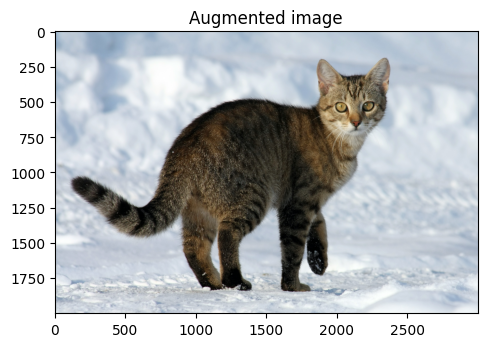

In [ ]:
flipped = tf.image.flip_left_right(image)
visualize(image, flipped)

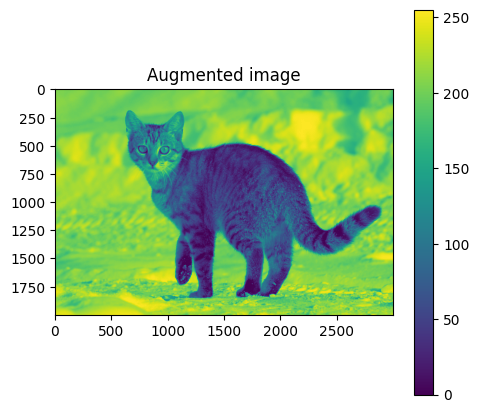

In [ ]:
grayscaled = tf.image.rgb_to_grayscale(image)
visualize(image, tf.squeeze(grayscaled))
plt.colorbar()

In [ ]:
saturated = tf.image.adjust_saturation(image, 3)  # Increase saturation by a factor of 3



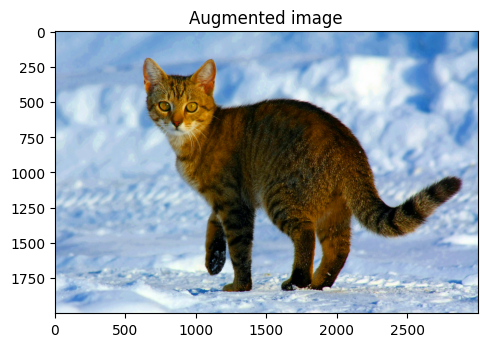

In [ ]:
visualize(image, saturated)



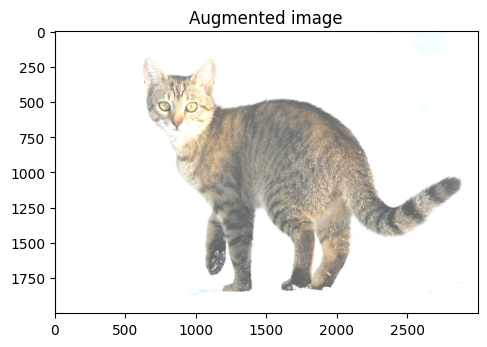

In [ ]:
bright = tf.image.adjust_brightness(image, 0.4)
visualize(image, bright)

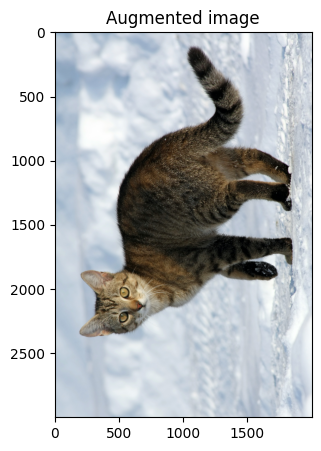

In [ ]:
rotated = tf.image.rot90(image)
visualize(image, rotated)

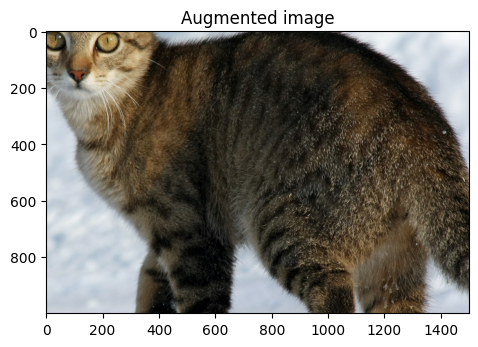

In [ ]:
cropped = tf.image.central_crop(image, central_fraction=0.5)
visualize(image, cropped)

## Data Augmentation on a Dataset and Training a Model

In [ ]:
dataset, info = tfds.load("mnist", as_supervised=True, with_info=True)
train_dataset, test_dataset = dataset["train"], dataset["test"]

num_train_examples= info.splits["train"].num_examples

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


In [ ]:
def convert(image, label):
  image = tf.image.convert_image_dtype(image, tf.float32)
  return image, label

def augment(image, label):
  image,label = convert(image, label)
  image = tf.image.convert_image_dtype(image, tf.float32)
  image = tf.image.resize_with_crop_or_pad(image, 34, 34)
  image = tf.image.random_crop(image, size=[28, 28, 1])
  image = tf.image.random_brightness(image, max_delta=0.5)

  return image, label

  BATCH_SIZE = 64

  NUM_EXAMPLES = 2048

In [ ]:
NUM_EXAMPLES = 2048
BATCH_SIZE = 64
AUTOTUNE = tf.data.AUTOTUNE

In [ ]:
augmented_train_batches = (
    train_dataset
    .take(NUM_EXAMPLES)
    .cache()
    .shuffle(num_train_examples//4)
    .map(augment, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

In [ ]:
non_augmented_train_batches = (
    train_dataset
    .take(NUM_EXAMPLES)
    .cache()
    .shuffle(num_train_examples//4)
    .map(convert, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

In [ ]:
validation_batches = (
    test_dataset
    .map(convert, num_parallel_calls=AUTOTUNE)
    .batch(2*BATCH_SIZE)
)

In [ ]:
def make_model():
  model = tf.keras.Sequential([
      layers.Flatten(input_shape=(28, 28, 1)),
      layers.Dense(4096, activation='relu'),
      layers.Dense(4096, activation='relu'),
      layers.Dense(10)
  ])
  model.compile(optimizer = "adam",
                loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=["accuracy"])
  return model

## Training the Model

In [ ]:
model_without_aug = make_model()

no_aug_history = model_without_aug.fit(
    non_augmented_train_batches,
    epochs=50,
    validation_data=validation_batches
)

Epoch 1/50
32/32 [==============================] - 30s 844ms/step - loss: 0.8631 - accuracy: 0.7427 - val_loss: 0.3588 - val_accuracy: 0.8896
Epoch 2/50
32/32 [==============================] - 25s 801ms/step - loss: 0.1819 - accuracy: 0.9419 - val_loss: 0.2865 - val_accuracy: 0.9138
Epoch 3/50
32/32 [==============================] - 37s 1s/step - loss: 0.0801 - accuracy: 0.9766 - val_loss: 0.3236 - val_accuracy: 0.9134
Epoch 4/50
32/32 [==============================] - 35s 1s/step - loss: 0.0447 - accuracy: 0.9863 - val_loss: 0.3226 - val_accuracy: 0.9205
Epoch 5/50
32/32 [==============================] - 35s 1s/step - loss: 0.0245 - accuracy: 0.9912 - val_loss: 0.3381 - val_accuracy: 0.9248
Epoch 6/50
32/32 [==============================] - 26s 812ms/step - loss: 0.0395 - accuracy: 0.9863 - val_loss: 0.4138 - val_accuracy: 0.9109
Epoch 7/50
32/32 [==============================] - 35s 1s/step - loss: 0.0572 - accuracy: 0.9800 - val_loss: 0.3979 - val_accuracy: 0.9169
Epoch 8/50


In [ ]:
model_with_aug = make_model()

aug_history = model_with_aug.fit(
    augmented_train_batches,
    epochs=50,
    validation_data=validation_batches
)

Epoch 1/50
32/32 [==============================] - 27s 819ms/step - loss: 2.3250 - accuracy: 0.3062 - val_loss: 1.1992 - val_accuracy: 0.6159
Epoch 2/50
32/32 [==============================] - 35s 1s/step - loss: 1.3873 - accuracy: 0.5420 - val_loss: 0.8464 - val_accuracy: 0.7573
Epoch 3/50
32/32 [==============================] - 25s 793ms/step - loss: 0.9393 - accuracy: 0.6855 - val_loss: 0.5066 - val_accuracy: 0.8630
Epoch 4/50
32/32 [==============================] - 25s 780ms/step - loss: 0.7827 - accuracy: 0.7310 - val_loss: 0.4162 - val_accuracy: 0.8744
Epoch 5/50
32/32 [==============================] - 35s 1s/step - loss: 0.6360 - accuracy: 0.7949 - val_loss: 0.3828 - val_accuracy: 0.8790
Epoch 6/50
32/32 [==============================] - 25s 786ms/step - loss: 0.5870 - accuracy: 0.7979 - val_loss: 0.3003 - val_accuracy: 0.9095
Epoch 7/50
32/32 [==============================] - 35s 1s/step - loss: 0.5683 - accuracy: 0.8052 - val_loss: 0.2895 - val_accuracy: 0.9129
Epoch 8/

(0.75, 1.0)

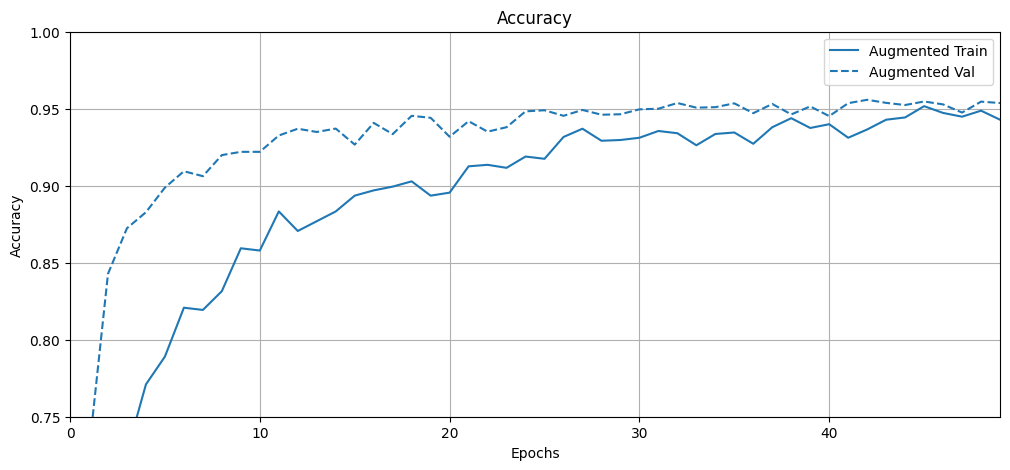

In [ ]:
plotter = tfdocs.plots.HistoryPlotter()
plotter.plot({"Augmented": aug_history}, metric = "accuracy")
plt.title("Accuracy")
plt.ylim([0.75,1])